In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datarepeat/data_to_gpt_2_final (6).txt
/kaggle/input/new-dataset/data_to_gpt_2_final (1).txt
/kaggle/input/data1dsf1/data_to_gpt_2_final (4).txt


In [2]:
!nvidia-smi


Fri Sep 15 05:47:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=c72f99c5d45f00c89edb6f9365c18fe97850d4be7ea0b1e782356c7bdddf7126
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr torch matplotlib nltk -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.2 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.2 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
cudf 23.4.0 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.20.2 which is incompatible.
beatrix-jupyterlab 2023.46.184821 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.
apache-beam 2

In [5]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from datasets import load_dataset,load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch
nltk.download("punkt")
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Model will be trained on {device}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Model will be trained on cuda


In [6]:
# !pip freeze

In [7]:

#loading model
model_ckpt = "Salesforce/codet5-base"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_before_training = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [8]:
#loading dataset

with open('/kaggle/input/data1dsf1/data_to_gpt_2_final (4).txt','r') as file:
    lines = file.readlines()

import re
test1 = []
for line in lines:
    test1.append(re.sub('  +', ' ', line))
test = [sub.replace("'", '').replace('\n','') for sub in test1]

inputs = []
outputs = []
for item in test:
    if test.index(item)%2==0:
        # print(item)
        inputs.append(item)
    if test.index(item)%2!=0:
        # print(item,'\n')
        outputs.append(item)



In [ ]:
from sklearn.model_selection import train_test_split
# data_train,data_val

In [23]:
dicts = {}
test_percentage = 0.9
data_index = int(test_percentage * len(inputs))
print(data_index)
dicts['prompt'] = inputs[:data_index]
dicts['code'] = outputs[:data_index]
data_train = pd.DataFrame(dicts)
data_train = data_train.sample(frac=1)
dicts = {}
dicts['prompt'] = inputs[data_index:]
dicts['code'] = outputs[data_index:]
data_val = pd.DataFrame(dicts)
data_val = data_val.sample(frac=1)

851


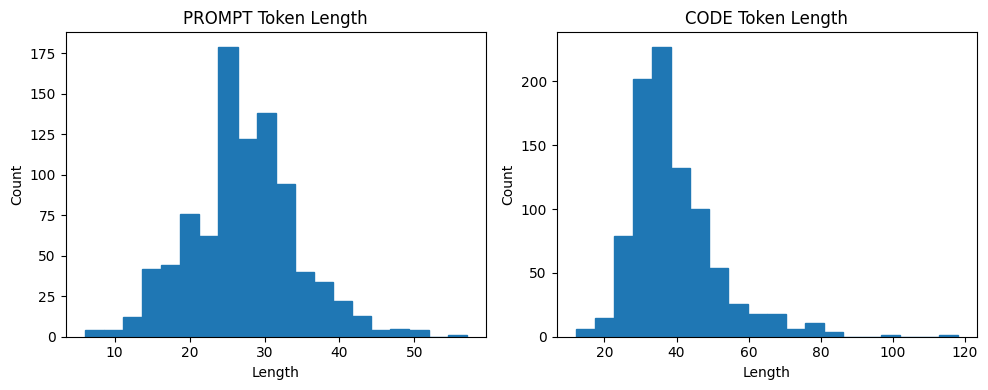

In [12]:
# histogram of length of dialogue and summary

prompt_token_length = [len(tokenizer.encode(s)) for s in data_train['prompt'] ]
code_token_length = [len(tokenizer.encode(s))for s in data_train['code']]

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(prompt_token_length, bins=20, color='C0',edgecolor='C0')
axes[0].set_title("PROMPT Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(code_token_length, bins=20, color='C0',edgecolor='C0')
axes[1].set_title("CODE Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [13]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    for i in range(0,len(list_of_elements),batch_size):
        yield list_of_elements[i:i+batch_size]



#code for computing rouge score
def calculate_metric_on_test_ds(datasets,metric,model,tokenizer,
                                batch_size=2,device=device,column_prompt="prompt",
                                column_code="code"):
    prompt_batches = list(generate_batch_sized_chunks(datasets[column_prompt].tolist(),batch_size))

    code_batches = list(generate_batch_sized_chunks(datasets[column_code].tolist(),batch_size))


  for prompt_batch, code_batch in tqdm(
      zip(prompt_batches, code_batches), total = len(prompt_batches)):
    prompts = tokenizer(prompt_batch , max_length=128,truncation=True,
                        padding="max_length",)
    codes = model.generate(input_ids = torch.tensor(prompts["input_ids"]).to(device),
                           attention_mask = torch.tensor(prompts["attention_mask"]).to(device),
                           length_penalty = 0.8, num_beams=8, max_length = 128)
    
    decoded_codes = [tokenizer.decode(s,skip_special_tokens=True,
                                      clean_up_tokenization_spaces=True)
    for s in codes]

    decoded_codes = [d.replace("<n>"," ") for d in decoded_codes]

    metric.add_batch(predictions = decoded_codes, references=code_batch)

  score = metric.compute()
  return score

In [ ]:
pipe = pipeline('text2text-generation', model = model_ckpt)
# pipe = pipeline('summarization', model = model_ckpt)
pipe_out = pipe(data_val['prompt'][5])

modelname = "name_of_your_model"

with open(f"Results_before_finetuning_{modelname}.txt",'a') as f:
    print("Input Prompt:")
    print(data_val['prompt'][5])

    print("Actual Output")
    print(data_val['code'][5])

    print("Generated Output Before Training: ")
    print(pipe_out)
#     f.write("These below inputs and outputs are before training the model:"+'\n')
#     f.write("Input Prompt:"+'\n')
#     f.write(data_val['prompt'][5]+'\n')
#     f.write("Actual Output"+'\n')
#     f.write(data_val['code'][5]+'\n')
#     f.write("Generated Output Before Training: ")
# #     f.write(pipe_out[0]['generated_text'])
#     f.write(pipe_out[0]['summary_text'])

In [16]:
rouge_names = ["rouge1","rouge2","rougeL","rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(data_val,rouge_metric,model_before_training,tokenizer=tokenizer)

rouge_dict = dict((rn,score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index = ['model'])

100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


,rouge1,rouge2,rougeL,rougeLsum
model,0.171669,0.067277,0.167364,0.167048


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer=tokenizer, max_input_length=128, max_target_length=128):
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
        self.inputs = data['prompt'].tolist()
        print(self.inputs[0])
        self.targets = data['code'].tolist()
        print(self.targets[0])

    def __getitem__(self, index):
      # print("inside getitem")
      input_encoding = self.tokenizer(self.inputs[index], max_length=self.max_input_length, truncation=True)
        # target_encoding = self.tokenizer(self.targets[index], max_length=self.max_target_length, truncation=True)
        with self.tokenizer.as_target_tokenizer():
            target_encoding = self.tokenizer(self.targets[index], max_length=self.max_target_length, truncation=True)

        return {
            'input_ids': input_encoding['input_ids'],
            'attention_mask': input_encoding['attention_mask'],
            'labels': target_encoding['input_ids']
        }

    def __len__(self):
        return len(self.inputs)



# dataset_pt = data_train.map(convert_examples_to_features,batched=True)
# dataset_pt_train = convert_examples_to_features(data_train)
# dataset_pt_eval = convert_examples_to_features(data_val)
dataset_pt_train_class = MyDataset(data_train)
dataset_pt_eval_class = MyDataset(data_val)

In [18]:
from transformers import DataCollatorForSeq2Seq
import time
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer,model = model_before_training)
from transformers import TrainingArguments, Trainer
start = time.time()
trainer_args = TrainingArguments(output_dir='./result_for'+'_'+ modelname,
                                 num_train_epochs = 100,
                                 warmup_steps = 100,
                                 per_device_train_batch_size = 8,
                                 per_device_eval_batch_size = 8,
                                 weight_decay = 0.0001,
                                 logging_steps = 10,
                                 push_to_hub = False,

                                 evaluation_strategy = 'steps',
                                 eval_steps = 100,
                                 save_steps = 1e6,
                                 gradient_accumulation_steps = 16,)

trainer = Trainer(
    model = model_before_training,
    args = trainer_args,
    train_dataset=dataset_pt_train_class,
    eval_dataset = dataset_pt_eval_class,
    data_collator = seq2seq_data_collator
)

trainer.train()

trainer.save_model("./fine-tuned_"+modelname)

end = time.time()

total_time = end-start

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,0.110500,0.020963
200,0.027400,0.000524
300,0.012200,0.000158
400,0.008300,0.000057
500,0.005700,0.000066
600,0.004100,0.000047
700,0.004100,0.000032


In [19]:
rouge_names = ["rouge1","rouge2","rougeL","rougeLsum"]

rouge_metric = load_metric('rouge')

# score = calculate_metric_on_test_ds(data_val,rouge_metric,model_before_training,tokenizer=tokenizer)


score = calculate_metric_on_test_ds(
    data_val,rouge_metric,model = trainer.model,tokenizer = tokenizer,)

rouge_dict = dict((rn,score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index = ['Fine Tuned Model'])

100%|██████████| 23/23 [00:17<00:00,  1.34it/s]


,rouge1,rouge2,rougeL,rougeLsum
Fine Tuned Model,1.0,1.0,1.0,1.0


In [20]:
#testing
gen_kwargs = {"length_penalty":0.8,"num_beams":8,"max_length":256}
del model_before_training

sample_text = data_val['prompt'][5]
# tokenizer1 = AutoTokenizer.from_pretrained(model_ckpt)
reference = data_val['code'][5]
trained_model = AutoModelForSeq2SeqLM.from_pretrained("fine-tuned_"+modelname)
pipe_from_trained = pipeline('text2text-generation', model =trained_model,tokenizer = tokenizer)

In [ ]:
print("prompt")
print(sample_text)

print("\n Actual Code")
print(reference)

print("\n Generated Code")
print(pipe_from_trained(sample_text, **gen_kwargs))

In [ ]:
with open(f"Results_of_code_generated_from_{modelname}details",'a') as f:
    f.write("Model Details are as follows:"+'\n')
    f.write("Name : "+model_ckpt+'\n')
    f.write(f"Trained For {100} epochs"+'\n')
    f.write(f"Trained on 208 Data Points"+'\n')
    f.write(f"Time for Code Training : {total_time}"+'\n')